In [6]:
import tifffile as tiff
import matplotlib.pyplot as plt
from PIL import Image

<h2>Segmentation</h2>

In [7]:
def read_and_crop(cellbound,i):
    return tiff.imread('../../data/raw/Vizgen/test/mosaic_{}_z{}.tif'.format(cellbound,i))[5800:10300,6100:10400]


def show_marker_images(marker):

    imgs = [read_and_crop(marker,i) for i in range(6)]

    # Create subplots
    fig, axes = plt.subplots(1, 6, figsize=(16, 7))

    # Flatten the axes array for easy indexing
    axes = axes.ravel()

    # Show images
    for i, img in enumerate(imgs):
        axes[i].imshow(img)
        axes[i].set_title(marker + ' ' + str(i))
        axes[i].axis("off")

    plt.show()

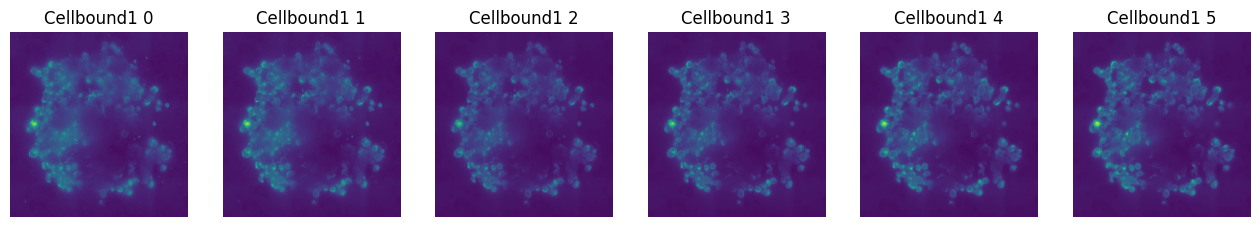

In [8]:
markers = ['Cellbound1','Cellbound2','Cellbound3','GFP','DAPI','PolyT']

show_marker_images(markers[0]) #Cellbound

In [ ]:
from cellpose import models
from cellpose.io import imread
import matplotlib.pyplot as plt

# Load image (grayscale)
img = read_and_crop('Cellbound1',5)  # Make sure it's 2D or 3D with channels last

model = models.Cellpose(model_type='cyto')

masks = []
# Not really interesting under 80
diameters = [100,120,140]
for d in diameters:
    mask, flows, styles, diams = model.eval(img, diameter=d, channels=[0, 0])
    masks.append(mask)

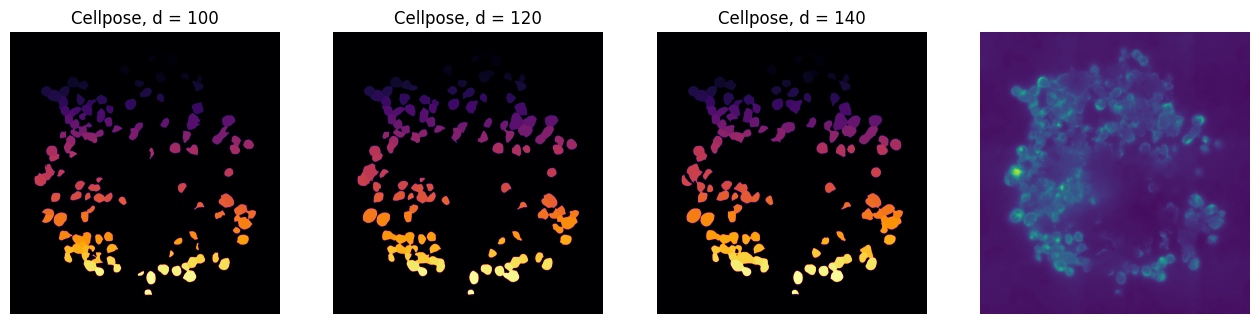

3

In [27]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes = axes.ravel()

for i,d in enumerate(diameters):
        axes[i].imshow(masks[i],cmap='inferno')
        axes[i].set_title('Cellpose, d = {}'.format(d))
        axes[i].axis("off")

axes[3].imshow(img)
axes[3].axis('off')

plt.show()
len(masks)

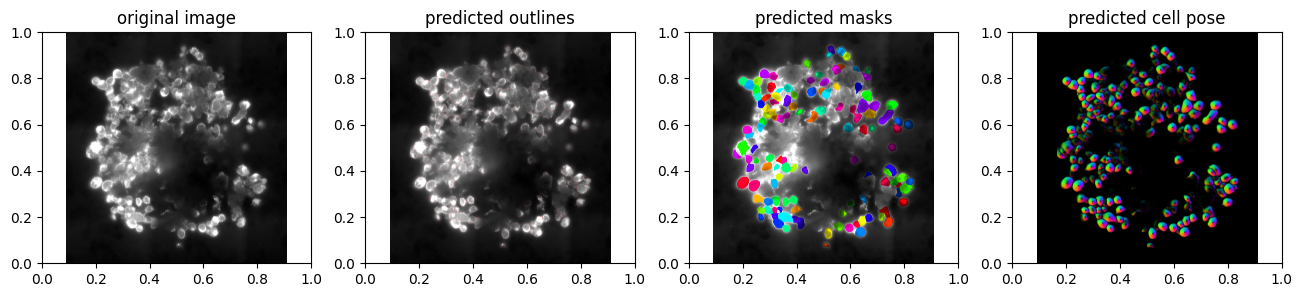

In [34]:
from cellpose import plot
fig, ax = plt.subplots(1,4,figsize=(16,3))
plot.show_segmentation(fig,img, mask, flows[0], channels=[0,0],)
plt.show()

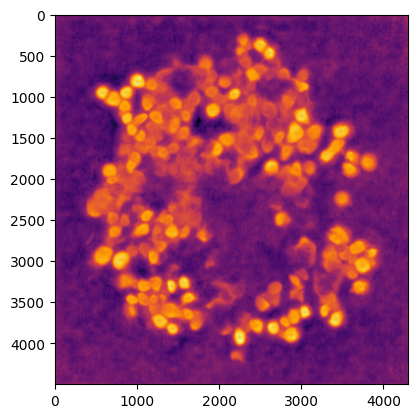

In [61]:
plt.imshow(flows[2], cmap='inferno')

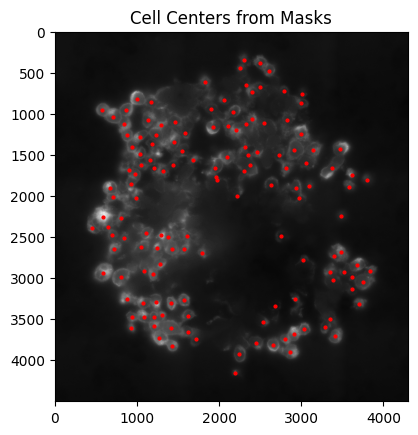

In [43]:
import numpy as np
from scipy.ndimage import center_of_mass

cell_ids = np.unique(mask)
cell_ids = cell_ids[cell_ids != 0]
centers = center_of_mass(mask > 0, labels=mask, index=cell_ids)

# Plot the original image with centers
plt.imshow(img, cmap='gray')
for y, x in centers:
    plt.plot(x, y, 'r.', markersize=4)
plt.title('Cell Centers from Masks')
plt.show()

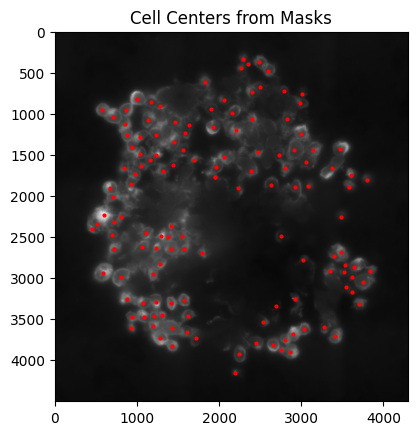

In [45]:
cell_ids2 = np.unique(masks[1])
cell_ids2 = cell_ids2[cell_ids2 != 0]
centers2 = center_of_mass(masks[1] > 0, labels=masks[1], index=cell_ids2)

# Plot the original image with centers
plt.imshow(img, cmap='gray')
for y, x in centers2:
    plt.plot(x, y, 'r.', markersize=4)
plt.title('Cell Centers from Masks')
plt.show()

In [52]:
import math
def closest_center(center,other_centers,dist_max):
    min_dist = dist_max
    closest_center = center
    idx = 0
    for i,c in enumerate(other_centers):
        dist = math.sqrt((center[0]-c[0])**2 + (center[1]-c[1])**2)
        if dist < min_dist:
            min_dist=dist
            closest_center = c
            idx = i+1

    return closest_center, idx

def link_centers(centers1, centers2):
    tab_idx = []
    tab_centers = []
    for i,c in enumerate(centers1):
        closest_c, idx = closest_center(c,centers2,1000)
        tab_idx.append([i+1,idx])
        tab_centers.append([c,closest_c])
    return tab_centers, tab_idx


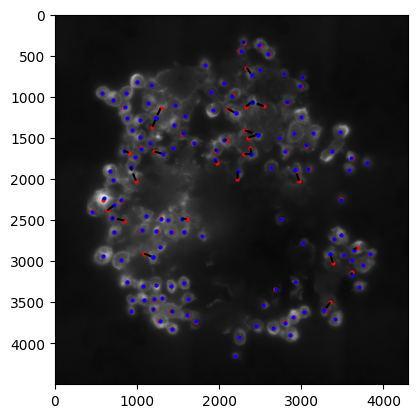

In [58]:
tab_centers, tab_idx = link_centers(centers,centers2)
plt.imshow(img, cmap='gray')
for c1,c2 in tab_centers:
    plt.plot(c1[1], c1[0], 'ro', markersize=2)
    plt.plot(c2[1], c2[0], 'bo', markersize=2)
    plt.plot([c1[1], c2[1]], [c1[0], c2[0]], 'k--', label='Link')

In [60]:
from skimage.measure import regionprops

props = regionprops(mask)

for i, p in enumerate(props):
    print(f"Cell {i+1}:")
    print(f" - Area: {p.area}")
    print(f" - Centroid: {p.centroid}")
    print(f" - Perimeter: {p.perimeter}")
    print(f" - Eccentricity: {p.eccentricity}")
    print(f" - Orientation: {p.orientation}")
    print(f" - Major axis length: {p.major_axis_length}")
    print(f" - Minor axis length: {p.minor_axis_length}")
    print() 

Cell 1:
 - Area: 17190.0
 - Centroid: (345.5138452588714, 2304.5416521233274)
 - Perimeter: 536.3574311003804
 - Eccentricity: 0.7885919715392432
 - Orientation: 0.6177849823555162
 - Major axis length: 191.16331603497858
 - Minor axis length: 117.54953947017606

Cell 2:
 - Area: 22318.0
 - Centroid: (375.8954655435075, 2491.549421991218)
 - Perimeter: 585.3940110268397
 - Eccentricity: 0.24486908657447476
 - Orientation: 0.7330734182887702
 - Major axis length: 172.78732067027542
 - Minor axis length: 167.52700961507205

Cell 3:
 - Area: 20653.0
 - Centroid: (476.6788844235704, 2602.126664407108)
 - Perimeter: 560.9259735953042
 - Eccentricity: 0.42080624703820185
 - Orientation: -0.11278937191328144
 - Major axis length: 171.00685838379837
 - Minor axis length: 155.12896394837043

Cell 4:
 - Area: 10376.0
 - Centroid: (447.05917501927524, 2259.6875481881266)
 - Perimeter: 401.10259710444143
 - Eccentricity: 0.5129526717426799
 - Orientation: -1.0469773861718537
 - Major axis length: 